In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pycaret.regression 
import pycaret.clustering
import pycaret.classification
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
from helper_functions import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

In [59]:
setup_data = {"number_of_snippets": 100, "previous_days":600, "snippet_size":30,
                 "projection_step":10, "scaling":"minmax", "n_clusters":10}

list_of_indexes = ['NYA', 'IXIC', 'HSI', 'GSPTSE', 'NSEI', 'GDAXI', 'KS11', 'SSMI', 'TWII',  'N225', 'N100']


# 0. Data import

We will use data from 11 indexes, with information from the last 600 trading days, back from May 2021. We then will create "snippets", fragments of the data from a random pivot day back 30 days, and a target value, the percentage increase or decrease between the pivot day and the prediction day, 20 days after that pivot day. So we will have closing prices and volume data for 30 days, a percentage of change for 20 days after that, for 100 "snippets" for each index. The price and volume for each are normalised using a minmax function, which will help clustering the trends and applying the classification and regression models.

In [63]:
initial_df = create_initial_df(list_of_indexes=list_of_indexes, setup_data=setup_data)

In [64]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 99
Data columns (total 63 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Vol0          1100 non-null   float64       
 1   Vol1          1100 non-null   float64       
 2   Vol2          1100 non-null   float64       
 3   Vol3          1100 non-null   float64       
 4   Vol4          1100 non-null   float64       
 5   Vol5          1100 non-null   float64       
 6   Vol6          1100 non-null   float64       
 7   Vol7          1100 non-null   float64       
 8   Vol8          1100 non-null   float64       
 9   Vol9          1100 non-null   float64       
 10  Vol10         1100 non-null   float64       
 11  Vol11         1100 non-null   float64       
 12  Vol12         1100 non-null   float64       
 13  Vol13         1100 non-null   float64       
 14  Vol14         1100 non-null   float64       
 15  Vol15         1100 non-null   float64   

In [65]:
initial_df["Target_value"].describe()

count    1100.000000
mean        0.539857
std         4.469005
min       -27.914343
25%        -0.945689
50%         0.977894
75%         2.823462
max        15.309034
Name: Target_value, dtype: float64

In [66]:
Features = initial_df.drop(columns=["Pivot_date"])
y_test = initial_df["Target_value"]

In [67]:
print(Features.shape, y_test.shape)

(1100, 62) (1100,)


# 1. Trends clustering model

First we have to drop the pivot value and the target value so the clustering model receives only the normalized trend data.

In [68]:
X_cluster_train = Features.drop(columns=["Pivot_value", "Target_value"])

We will use custom functions to calculate an elbow and silhouette graph:

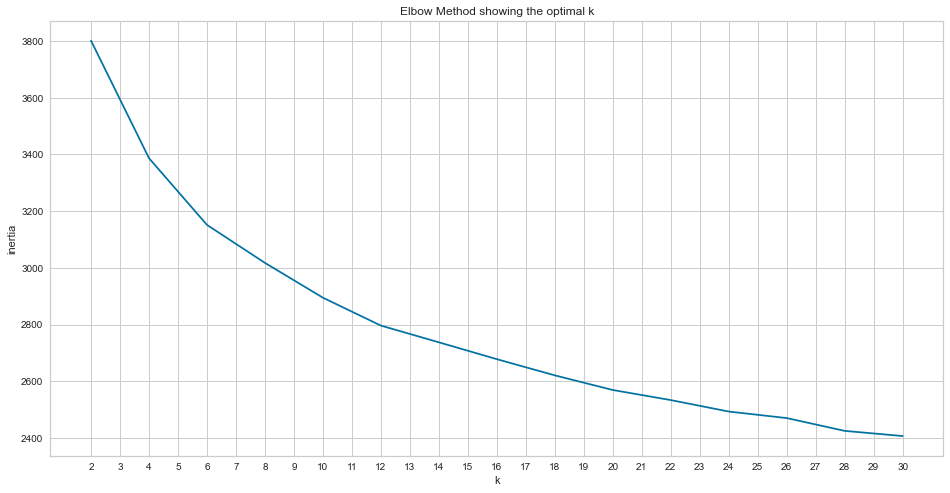

In [69]:
elbow_graph(X_cluster_train)

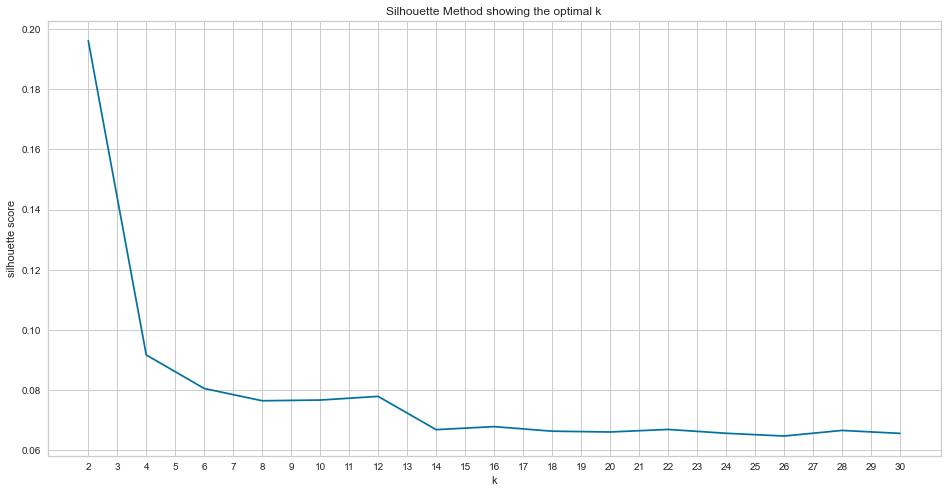

In [70]:
silhouette_graph(X_cluster_train)

We will create 10 clusters, one for each main trend. Next, we will train a model with our training data and visualise the trends that the clustering is trying to capture.

In [71]:
clustering_model = KMeans(init="k-means++", n_clusters=10)

In [72]:
#We fit the Kmeans to the training data
clustering_model.fit(X_cluster_train)

#We create the arrays with the predicted clusters
clusters_train = clustering_model.predict(X_cluster_train)

#We incorporate the clusters to the training and test dataframes, and cast them to objects
df_clusters = Features.copy()
df_clusters["Cluster"] = clusters_train
df_clusters["Cluster"]= df_clusters["Cluster"].astype(object)


In [73]:
df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 99
Data columns (total 63 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vol0          1100 non-null   float64
 1   Vol1          1100 non-null   float64
 2   Vol2          1100 non-null   float64
 3   Vol3          1100 non-null   float64
 4   Vol4          1100 non-null   float64
 5   Vol5          1100 non-null   float64
 6   Vol6          1100 non-null   float64
 7   Vol7          1100 non-null   float64
 8   Vol8          1100 non-null   float64
 9   Vol9          1100 non-null   float64
 10  Vol10         1100 non-null   float64
 11  Vol11         1100 non-null   float64
 12  Vol12         1100 non-null   float64
 13  Vol13         1100 non-null   float64
 14  Vol14         1100 non-null   float64
 15  Vol15         1100 non-null   float64
 16  Vol16         1100 non-null   float64
 17  Vol17         1100 non-null   float64
 18  Vol18         1100 non-null   

Now we try to visualise what the clustering model does:
1. With a PCA decomposition
2. Visualising some trends for each cluster, and see if they seem related.

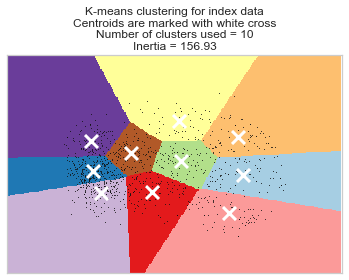

In [74]:
visualise_clustering_pca(X_cluster_train, init_algo="k-means++", n_clusters=10, n_init=4)

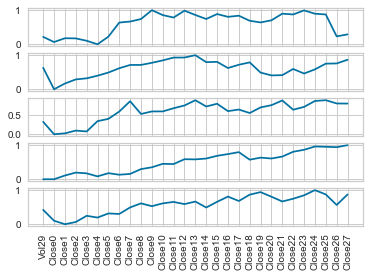

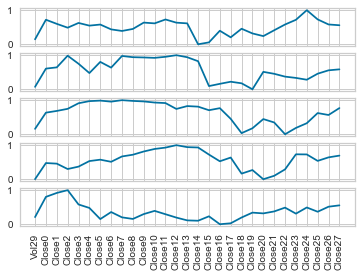

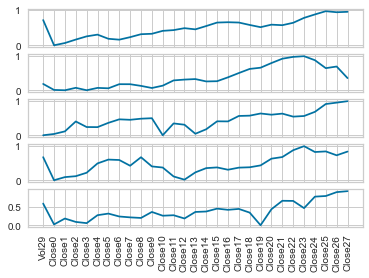

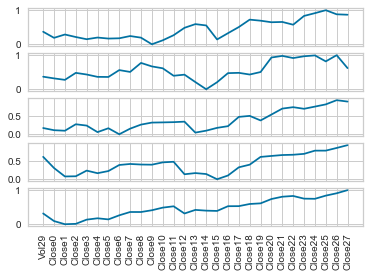

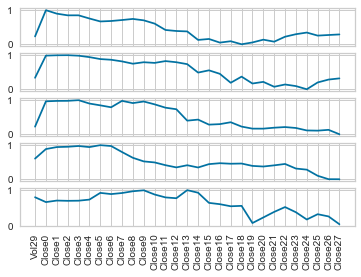

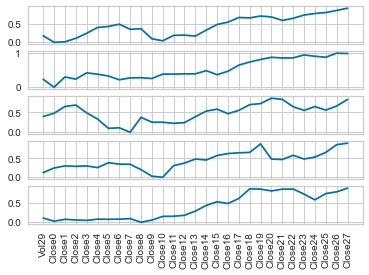

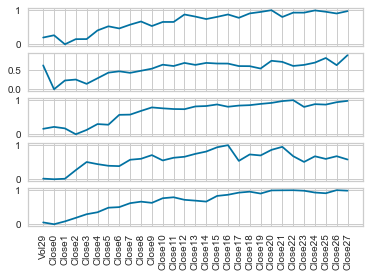

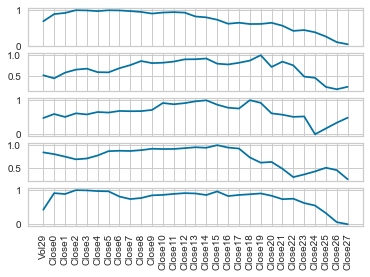

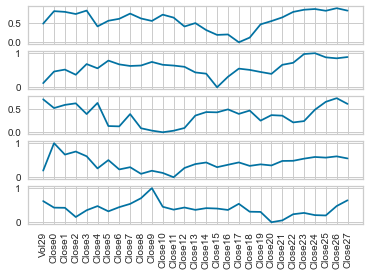

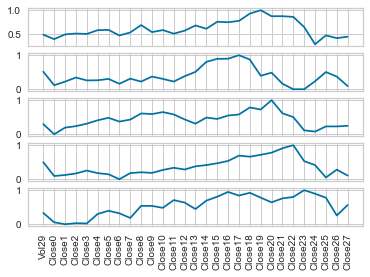

In [75]:
visualising_clusters_df = df_clusters.drop(columns=["Pivot_value", "Target_value"])
visualise_clusters(visualising_clusters_df, n_per_cluster=5)

# 2. Classification model - good, bad, neutral categories

In order to feed better information to the regression model, we will train a classification model with the full data (initial plus clusters) in order to divide the trends in 3 categories: good, bad and neutral. 

1. First we add a column that will be called Class_category. It will come from calculating the percentage of change between the pivot and target values, and transforming it into categories depending on that percentage.

In [76]:
def get_label(x):
    labels = ["Bad", "Neutral", "Good"]
    if x < -1:
        return labels[0]
    elif x < 3:
        return labels[1]
    else:
        return labels[2]

In [77]:
df_class = df_clusters.copy()

df_class["Class_category"] = df_class["Target_value"].apply(get_label)

In [78]:
df_class["Class_category"].value_counts()

Neutral    582
Bad        267
Good       251
Name: Class_category, dtype: int64

2. Then we run the classification model, using PyCaret, an automatized ML tool, in order to evaluate the different options and visualise the results.

In [79]:
X_train_class = df_class.drop(columns=["Pivot_value", "Target_value"])

clf1 = pycaret.classification.setup(X_train_class, target = "Class_category", remove_perfect_collinearity=False, silent=True)

,Description,Value
0,session_id,2759
1,Target,Class_category
2,Target Type,Multiclass
3,Label Encoded,"Bad: 0, Good: 1, Neutral: 2"
4,Original Data,"(1100, 62)"
5,Missing Values,False
6,Numeric Features,60
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [80]:
best_class = pycaret.classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6307,0.7175,0.4959,0.6932,0.5786,0.2804,0.3463,0.1700
rf,Random Forest Classifier,0.6151,0.6903,0.4775,0.6631,0.5592,0.2512,0.3088,0.1930
lightgbm,Light Gradient Boosting Machine,0.5774,0.6699,0.4708,0.5681,0.5423,0.2171,0.2363,0.1840
gbc,Gradient Boosting Classifier,0.5735,0.6514,0.4674,0.5688,0.5398,0.2127,0.2318,0.5300
knn,K Neighbors Classifier,0.5356,0.6338,0.4757,0.5342,0.5265,0.2111,0.2144,0.0490
lr,Logistic Regression,0.5291,0.6032,0.4103,0.4953,0.4841,0.1261,0.1400,0.2650
ridge,Ridge Classifier,0.5265,0.0000,0.4047,0.4948,0.4787,0.1208,0.1353,0.0040
qda,Quadratic Discriminant Analysis,0.5228,0.5831,0.4518,0.5617,0.4773,0.1727,0.2027,0.0090
lda,Linear Discriminant Analysis,0.5226,0.6060,0.4164,0.4966,0.4867,0.1342,0.1448,0.0080
ada,Ada Boost Classifier,0.5150,0.5747,0.4112,0.4847,0.4816,0.1188,0.1257,0.0570


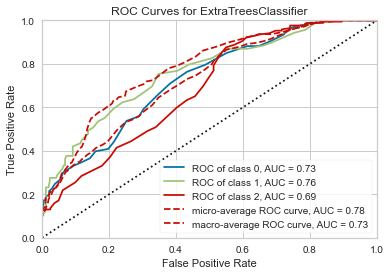

In [81]:
pycaret.classification.plot_model(best_class)

In [82]:
pycaret.classification.evaluate_model(best_class)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

The results are far from perfect but it we believe it is a good tool for the regression model. That is why we will create a classification model to run on the test data.

# 3. Regression model using clustering and classification results

Now we will use Pycaret to study which regression models are more useful. The pivot value, only price data that is not normalised, will not be used for the modeling, it is only used after we calculate a target percentage change, in order to caluculate the predicted price. We will have several scenarios:
1. Passing all the information, including price, volumes, classification category and clusters, to the model.
2. Only passing the calculated clusters and classification category.
3. Passing only the calculated clusters.
4. Passing only the volume information and price information.

## 3.1 All the information

In [83]:
regression_data_1 = df_class.copy()
regression_data_1 = regression_data_1.drop(columns="Pivot_value")

In [84]:
regression_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 99
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Vol0            1100 non-null   float64
 1   Vol1            1100 non-null   float64
 2   Vol2            1100 non-null   float64
 3   Vol3            1100 non-null   float64
 4   Vol4            1100 non-null   float64
 5   Vol5            1100 non-null   float64
 6   Vol6            1100 non-null   float64
 7   Vol7            1100 non-null   float64
 8   Vol8            1100 non-null   float64
 9   Vol9            1100 non-null   float64
 10  Vol10           1100 non-null   float64
 11  Vol11           1100 non-null   float64
 12  Vol12           1100 non-null   float64
 13  Vol13           1100 non-null   float64
 14  Vol14           1100 non-null   float64
 15  Vol15           1100 non-null   float64
 16  Vol16           1100 non-null   float64
 17  Vol17           1100 non-null   flo

In [85]:
reg1 = pycaret.regression.setup(regression_data_1, target = "Target_value", 
                                remove_perfect_collinearity=False, silent=True) 

,Description,Value
0,session_id,1343
1,Target,Target_value
2,Original Data,"(1100, 63)"
3,Missing Values,False
4,Numeric Features,60
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(769, 73)"


In [86]:
best = pycaret.regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.3590,5.0435,2.1724,0.7803,0.3989,1.9220,0.2320
ada,AdaBoost Regressor,1.6748,5.4935,2.3134,0.7444,0.4531,2.4176,0.0650
gbr,Gradient Boosting Regressor,1.4931,5.7703,2.3327,0.7439,0.4409,2.1046,0.1810
lightgbm,Light Gradient Boosting Machine,1.5024,5.8108,2.3509,0.7332,0.4481,1.8931,0.0760
rf,Random Forest Regressor,1.5113,6.0527,2.3851,0.7310,0.4212,1.9824,0.3330
knn,K Neighbors Regressor,1.6824,6.9907,2.6084,0.6733,0.4927,1.8486,0.0360
br,Bayesian Ridge,1.8432,8.7433,2.8881,0.6138,0.5048,2.4092,0.0060
omp,Orthogonal Matching Pursuit,1.8626,9.0570,2.9306,0.6060,0.4924,2.1772,0.0060
ridge,Ridge Regression,1.9213,8.9704,2.9339,0.5988,0.5300,2.6585,0.0060
lr,Linear Regression,1.9531,9.1225,2.9613,0.5905,0.5389,2.7327,0.0120


Let's analyse a Light Gradient Boosting Machine model's results:

In [87]:
lightgbm = pycaret.regression.create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.4465,4.7955,2.1899,0.7242,0.4861,1.9749
1,1.3593,5.1752,2.2749,0.7171,0.4066,1.5580
2,1.5120,7.9181,2.8139,0.7570,0.4295,2.0477
3,1.3588,4.0528,2.0132,0.8134,0.4284,1.4745
4,1.5507,4.3354,2.0822,0.7646,0.4914,3.6791
5,1.1616,2.4747,1.5731,0.8866,0.4043,2.4760
6,1.9212,11.1126,3.3336,0.7421,0.4780,1.4003
7,1.7496,8.4358,2.9044,0.6420,0.4791,1.5266
8,1.2838,2.8264,1.6812,0.7468,0.4379,1.7055
9,1.6808,6.9817,2.6423,0.5382,0.4399,1.0882


In [88]:
pycaret.regression.evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

We will tune the model's hyperparameters and finalise it, that is, train it with the rest of the NY index data (the training and test data).

In [89]:
tuned_model = pycaret.regression.tune_model(lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.3861,4.1801,2.0445,0.7596,0.4472,1.6181
1,1.2609,4.0964,2.0240,0.7761,0.3944,2.0627
2,1.7452,11.1121,3.3335,0.6590,0.4974,3.9061
3,1.5886,6.0323,2.4561,0.7223,0.4592,1.9956
4,1.6471,6.0256,2.4547,0.6728,0.4900,1.2761
5,1.4779,4.2842,2.0698,0.8037,0.4429,3.3204
6,2.1001,13.2677,3.6425,0.6921,0.5196,1.4626
7,1.6563,8.2205,2.8671,0.6511,0.4655,1.2985
8,1.2959,2.9014,1.7033,0.7400,0.4470,2.0444
9,1.7238,5.4617,2.3370,0.6388,0.4551,1.2900


In [90]:
final_model = pycaret.regression.finalize_model(tuned_model)

## 3.2 Only cluster and classification category

In [91]:
regression_data_2 = df_class[["Cluster", "Class_category", "Target_value"]]

In [92]:
regression_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cluster         1100 non-null   object 
 1   Class_category  1100 non-null   object 
 2   Target_value    1100 non-null   float64
dtypes: float64(1), object(2)
memory usage: 34.4+ KB


In [93]:
reg2 = pycaret.regression.setup(regression_data_2, target = "Target_value", 
                                remove_perfect_collinearity=False, silent=True) 

,Description,Value
0,session_id,3065
1,Target,Target_value
2,Original Data,"(1100, 3)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(769, 13)"


In [94]:
best_2 = pycaret.regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.6803,7.4372,2.6899,0.6399,0.4457,5.1814,0.0080
gbr,Gradient Boosting Regressor,1.6873,7.5084,2.7025,0.6362,0.4468,5.0727,0.0210
et,Extra Trees Regressor,1.6898,7.5282,2.7072,0.6346,0.4477,5.2034,0.1490
dt,Decision Tree Regressor,1.6898,7.5282,2.7072,0.6346,0.4477,5.2034,0.0060
rf,Random Forest Regressor,1.6930,7.5602,2.7142,0.6313,0.4484,5.1832,0.1480
ada,AdaBoost Regressor,1.7755,7.8227,2.7743,0.6038,0.4635,5.3241,0.0070
br,Bayesian Ridge,1.8012,8.6950,2.8891,0.5940,0.4785,3.1859,0.0060
ridge,Ridge Regression,1.8054,8.6962,2.8898,0.5936,0.4793,3.1759,0.0060
lar,Least Angle Regression,1.8128,8.6988,2.8913,0.5929,0.4807,3.1598,0.0060
lr,Linear Regression,1.8169,8.7304,2.8956,0.5918,0.4791,3.5764,0.0120


We will keep the Gradient Boosting Regressor.

In [95]:
gbr = pycaret.regression.create_model("gbr")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.6658,6.4951,2.5486,0.6772,0.4517,1.1901
1,1.4931,6.2628,2.5026,0.6393,0.4098,1.4234
2,1.7708,10.3617,3.2190,0.6176,0.4490,1.4121
3,1.6283,5.0574,2.2489,0.5837,0.4856,2.4441
4,2.2078,14.5526,3.8148,0.6382,0.4426,4.0874
5,1.8328,6.7024,2.5889,0.7363,0.4576,33.6177
6,1.4749,5.1408,2.2673,0.5932,0.4722,2.6213
7,1.6288,6.8611,2.6194,0.6520,0.4240,0.9875
8,1.5705,7.6495,2.7658,0.4730,0.4626,1.4870
9,1.6004,6.0011,2.4497,0.7519,0.4131,1.4567


In [96]:
pycaret.regression.evaluate_model(gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

We tune and finalize the model:

In [97]:
gbr = pycaret.regression.tune_model(gbr)
gbr  = pycaret.regression.finalize_model(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.6775,6.8780,2.6226,0.6582,0.4567,1.1934
1,1.4954,6.0718,2.4641,0.6503,0.4057,1.4176
2,1.7587,10.1236,3.1818,0.6264,0.4481,1.4106
3,1.5958,5.1282,2.2646,0.5779,0.4849,2.4536
4,2.1968,14.5289,3.8117,0.6388,0.4416,4.2519
5,1.8374,6.8376,2.6149,0.7309,0.4618,37.1264
6,1.4496,4.8471,2.2016,0.6164,0.4648,2.7380
7,1.5959,6.7355,2.5953,0.6583,0.4210,0.9751
8,1.5483,7.2993,2.7017,0.4971,0.4592,1.4840
9,1.5926,6.0842,2.4666,0.7484,0.4132,1.4203


## 3.3 Only calculated clusters

In [98]:
regression_data_3 = df_class[["Cluster", "Pivot_value", "Target_value"]]

In [99]:
reg3 = pycaret.regression.setup(regression_data_3, target = "Target_value", 
                                remove_perfect_collinearity=False, silent=True) 

,Description,Value
0,session_id,1249
1,Target,Target_value
2,Original Data,"(1100, 3)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(769, 11)"


In [100]:
best3 = pycaret.regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2.6533,17.1199,4.0506,0.0856,0.7713,2.6115,0.0240
br,Bayesian Ridge,2.7761,18.9084,4.2534,-0.0027,0.8913,2.0520,0.0050
ridge,Ridge Regression,2.7916,18.9421,4.2615,-0.0097,0.8916,2.4891,0.0060
lr,Linear Regression,2.7937,18.9566,4.2634,-0.0110,0.8913,2.5304,0.0110
lar,Least Angle Regression,2.7937,18.9566,4.2634,-0.0110,0.8913,2.5304,0.0060
huber,Huber Regressor,2.8362,19.3094,4.2928,-0.0175,0.9572,5.3901,0.0060
llar,Lasso Least Angle Regression,2.8196,19.4183,4.3024,-0.0197,0.8953,3.6148,0.0110
en,Elastic Net,2.8090,19.4296,4.3040,-0.0209,0.8957,2.4881,0.0060
lasso,Lasso Regression,2.8090,19.4296,4.3040,-0.0209,0.8957,2.4885,0.0060
lightgbm,Light Gradient Boosting Machine,2.8248,18.8581,4.2675,-0.0286,0.7783,6.5658,0.0090


The results are very bad, so we will drop this model.

### 3.4.- Volume and price data (no clusters or categories)

In [101]:
regression_data_4 = df_class.iloc[:,0:60]
regression_data_4["Pivot_value"] = df_class["Pivot_value"]
regression_data_4["Target_value"] = df_class["Target_value"]

In [102]:
reg4 = pycaret.regression.setup(regression_data_4, target = "Target_value", 
                                remove_perfect_collinearity=False, silent=True) 

,Description,Value
0,session_id,5477
1,Target,Target_value
2,Original Data,"(1100, 62)"
3,Missing Values,False
4,Numeric Features,61
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(769, 61)"


In [103]:
best4 = pycaret.regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.4024,13.3433,3.6345,0.3961,0.7861,3.8380,0.2410
lightgbm,Light Gradient Boosting Machine,2.5248,13.5471,3.6662,0.3740,0.7254,6.6318,0.0770
rf,Random Forest Regressor,2.6382,15.9061,3.9652,0.2921,0.8118,2.8996,0.4250
gbr,Gradient Boosting Regressor,2.7262,16.1328,3.9989,0.2710,0.7724,4.7150,0.1930
ada,AdaBoost Regressor,2.8873,16.2331,4.0168,0.2553,0.8708,2.7357,0.0720
br,Bayesian Ridge,3.0047,21.7048,4.6137,0.0636,0.8996,7.3300,0.0070
omp,Orthogonal Matching Pursuit,3.1100,21.9804,4.6424,0.0521,0.8989,11.2157,0.0060
ridge,Ridge Regression,3.1660,22.6160,4.7175,0.0154,0.8194,5.3551,0.0060
lr,Linear Regression,3.2024,22.8657,4.7445,0.0031,0.8182,4.2155,0.0130
en,Elastic Net,3.0578,23.3633,4.7816,-0.0027,1.0519,1.8922,0.0060


The results are also quite bad, not as bad as the "only clusters" model, but pretty bad nonetheless.

# 4. Conclusion

For our automatized program we will use a three-part model:
1. Clustering using KMeans with 10 clusters, with only the "trend" data (normalised price and volume), without the pivot or target values.
2. Classification model using a Random Forest Classifier. The input is the normalised data and the clusters. The target of the classification is a calculated category (bad, neutral or good), function of the percentage change (calculated value).
3. Regression model, a Light Gradient Boosting Machine to which we will feed all the data except for the pivot value, that is, the trend data (price and volume), the cluster and the classification category. The target value will be the percentage change between the pivot value and the projection day value.